<a href="https://colab.research.google.com/github/kridtapon/Mass-Momentum-Breakout/blob/main/Mass_Momentum_Breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# === Ultimate Oscillator ===
def calculate_ultimate_oscillator(df, short=7, medium=14, long=28):
    high = df['High']
    low = df['Low']
    close = df['Close']

    bp = close - np.minimum(low, close.shift(1))
    tr = np.maximum(high, close.shift(1)) - np.minimum(low, close.shift(1))

    avg7 = bp.rolling(window=short).sum() / tr.rolling(window=short).sum()
    avg14 = bp.rolling(window=medium).sum() / tr.rolling(window=medium).sum()
    avg28 = bp.rolling(window=long).sum() / tr.rolling(window=long).sum()

    ult_osc = 100 * (4 * avg7 + 2 * avg14 + avg28) / (4 + 2 + 1)
    return ult_osc

# === Mass Index ===
def calculate_mass_index(df, ema_period=9, mi_period=25):
    high_low_range = df['High'] - df['Low']
    ema1 = high_low_range.ewm(span=ema_period, adjust=False).mean()
    ema2 = ema1.ewm(span=ema_period, adjust=False).mean()
    mass = (ema1 / ema2).rolling(window=mi_period).sum()
    return mass

# === Parameters ===
symbol = 'ETH-USD'
start_date = '2019-01-01'
end_date = '2025-01-01'

# === Download Data ===
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Indicator Calculation ===
df['Ultimate'] = calculate_ultimate_oscillator(df)
df['MassIndex'] = calculate_mass_index(df)

# === Entry & Exit Logic ===
df['Entry'] = (df['Ultimate'] > 50) | (df['MassIndex'].shift(1) < 25) & (df['MassIndex'] >= 25)
df['Exit'] = (df['Ultimate'] < 50) | (df['MassIndex'].shift(1) > 25) & (df['MassIndex'] <= 25)

# === Filter for test period ===
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# === Shift for next-day execution ===
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# === Portfolio Construction ===
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Results ===
print(portfolio.stats())
portfolio.plot().show()


/tmp/ipython-input-4-2337464903.py:36: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4-2337464903.py:50: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-4-2337464903.py:51: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Start                                2020-01-01 00:00:00
End                                  2024-12-31 00:00:00
Period                                1827 days 00:00:00
Start Value                                     100000.0
End Value                                  912567.724085
Total Return [%]                              812.567724
Benchmark Return [%]                         2489.198226
Max Gross Exposure [%]                             100.0
Total Fees Paid                            293789.706245
Max Drawdown [%]                               66.495211
Max Drawdown Duration                 1212 days 00:00:00
Total Trades                                         146
Total Closed Trades                                  146
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   30.136986
Best Trade [%]                                257.910042
Worst Trade [%]                

/tmp/ipython-input-12-1414613671.py:35: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Best Ultimate Oscillator Params → short: 10, medium: 15, long: 30 with Total Return: 30.25


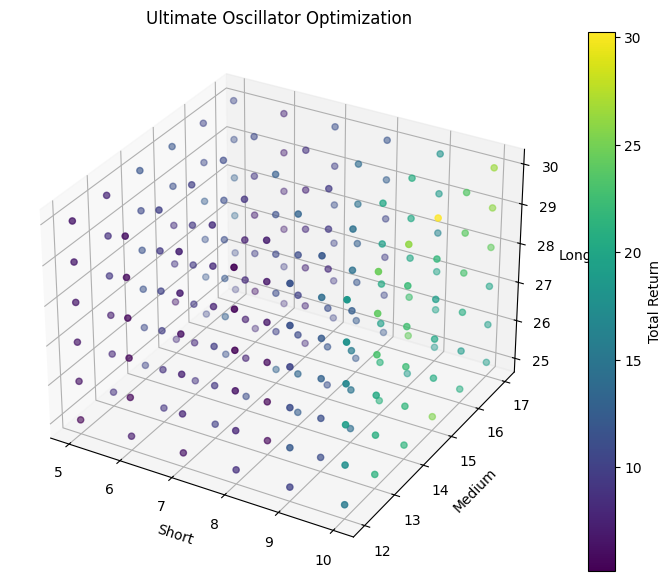

Best Mass Index Params → ema_period: 7, mi_period: 25 with Total Return: 10.43


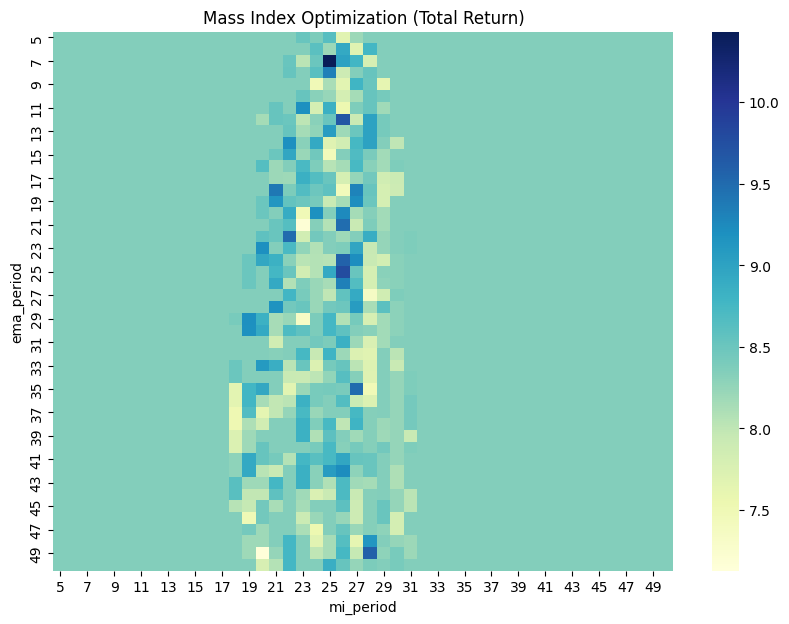

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

# === Ultimate Oscillator ===
def calculate_ultimate_oscillator(df, short=7, medium=14, long=28):
    high = df['High']
    low = df['Low']
    close = df['Close']
    bp = close - np.minimum(low, close.shift(1))
    tr = np.maximum(high, close.shift(1)) - np.minimum(low, close.shift(1))
    avg_s = bp.rolling(window=short).sum() / tr.rolling(window=short).sum()
    avg_m = bp.rolling(window=medium).sum() / tr.rolling(window=medium).sum()
    avg_l = bp.rolling(window=long).sum() / tr.rolling(window=long).sum()
    return 100 * (4 * avg_s + 2 * avg_m + avg_l) / 7

# === Mass Index ===
def calculate_mass_index(df, ema_period=9, mi_period=25):
    high_low_range = df['High'] - df['Low']
    ema1 = high_low_range.ewm(span=ema_period, adjust=False).mean()
    ema2 = ema1.ewm(span=ema_period, adjust=False).mean()
    return (ema1 / ema2).rolling(window=mi_period).sum()

# === Parameters ===
symbol = 'ETH-USD'
start_date = '2019-01-01'
end_date = '2025-01-01'

# === Download Data ===
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Optimization Section 1: short, medium, long ===
short_range = range(5, 11)
medium_range = range(12, 18)
long_range = range(25, 31)

results1 = []

for short, medium, long in product(short_range, medium_range, long_range):
    df['Ultimate'] = calculate_ultimate_oscillator(df, short, medium, long)
    df['MassIndex'] = calculate_mass_index(df)

    df['Entry'] = (df['Ultimate'] > 50) | ((df['MassIndex'].shift(1) < 25) & (df['MassIndex'] >= 25))
    df['Exit'] = (df['Ultimate'] < 50) | ((df['MassIndex'].shift(1) > 25) & (df['MassIndex'] <= 25))

    filtered_df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
    entries = filtered_df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    exits = filtered_df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    pf = vbt.Portfolio.from_signals(
        close=filtered_df['Open'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )

    results1.append((short, medium, long, pf.total_return()))

# === Print Best Parameters Section 1 ===
best1 = max(results1, key=lambda x: x[3])
print(f"Best Ultimate Oscillator Params → short: {best1[0]}, medium: {best1[1]}, long: {best1[2]} with Total Return: {best1[3]:.2f}")

# === 3D Plot ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
x = [r[0] for r in results1]
y = [r[1] for r in results1]
z = [r[2] for r in results1]
ret = [r[3] for r in results1]
sc = ax.scatter(x, y, z, c=ret, cmap='viridis')
ax.set_xlabel('Short')
ax.set_ylabel('Medium')
ax.set_zlabel('Long')
fig.colorbar(sc, label='Total Return')
plt.title("Ultimate Oscillator Optimization")
plt.show()

# === Optimization Section 2: ema_period, mi_period ===
ema_range = range(5, 51)
mi_range = range(5, 51)

heatmap = pd.DataFrame(index=ema_range, columns=mi_range)
results2 = []

for ema_period, mi_period in product(ema_range, mi_range):
    df['Ultimate'] = calculate_ultimate_oscillator(df)
    df['MassIndex'] = calculate_mass_index(df, ema_period, mi_period)

    df['Entry'] = (df['Ultimate'] > 50) | ((df['MassIndex'].shift(1) < 25) & (df['MassIndex'] >= 25))
    df['Exit'] = (df['Ultimate'] < 50) | ((df['MassIndex'].shift(1) > 25) & (df['MassIndex'] <= 25))

    filtered_df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
    entries = filtered_df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    exits = filtered_df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    pf = vbt.Portfolio.from_signals(
        close=filtered_df['Open'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )

    total_return = pf.total_return()
    results2.append((ema_period, mi_period, total_return))
    heatmap.loc[ema_period, mi_period] = total_return

# === Print Best Parameters Section 2 ===
best2 = max(results2, key=lambda x: x[2])
print(f"Best Mass Index Params → ema_period: {best2[0]}, mi_period: {best2[1]} with Total Return: {best2[2]:.2f}")

# === Heatmap Plot ===
plt.figure(figsize=(10, 7))
heatmap = heatmap.astype(float)
sns.heatmap(heatmap, annot=False, fmt=".2f", cmap="YlGnBu")
plt.title("Mass Index Optimization (Total Return)")
plt.xlabel("mi_period")
plt.ylabel("ema_period")
plt.show()


In [13]:
# === Indicator Calculation ===
df['Ultimate'] = calculate_ultimate_oscillator(df, short=10, medium=15, long=30)
df['MassIndex'] = calculate_mass_index(df, ema_period=7, mi_period=25)

# === Entry & Exit Logic ===
df['Entry'] = (df['Ultimate'] > 50) | (df['MassIndex'].shift(1) < 25) & (df['MassIndex'] >= 25)
df['Exit'] = (df['Ultimate'] < 50) | (df['MassIndex'].shift(1) > 25) & (df['MassIndex'] <= 25)

# === Filter for test period ===
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# === Shift for next-day execution ===
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# === Portfolio Construction ===
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Results ===
print(portfolio.stats())
portfolio.plot().show()

Start                                2020-01-01 00:00:00
End                                  2024-12-31 00:00:00
Period                                1827 days 00:00:00
Start Value                                     100000.0
End Value                                  3377120.51286
Total Return [%]                             3277.120513
Benchmark Return [%]                         2489.198226
Max Gross Exposure [%]                             100.0
Total Fees Paid                            486546.050502
Max Drawdown [%]                               46.770947
Max Drawdown Duration                  400 days 00:00:00
Total Trades                                         107
Total Closed Trades                                  107
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                    32.71028
Best Trade [%]                                261.109534
Worst Trade [%]                

/tmp/ipython-input-14-1832574325.py:36: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


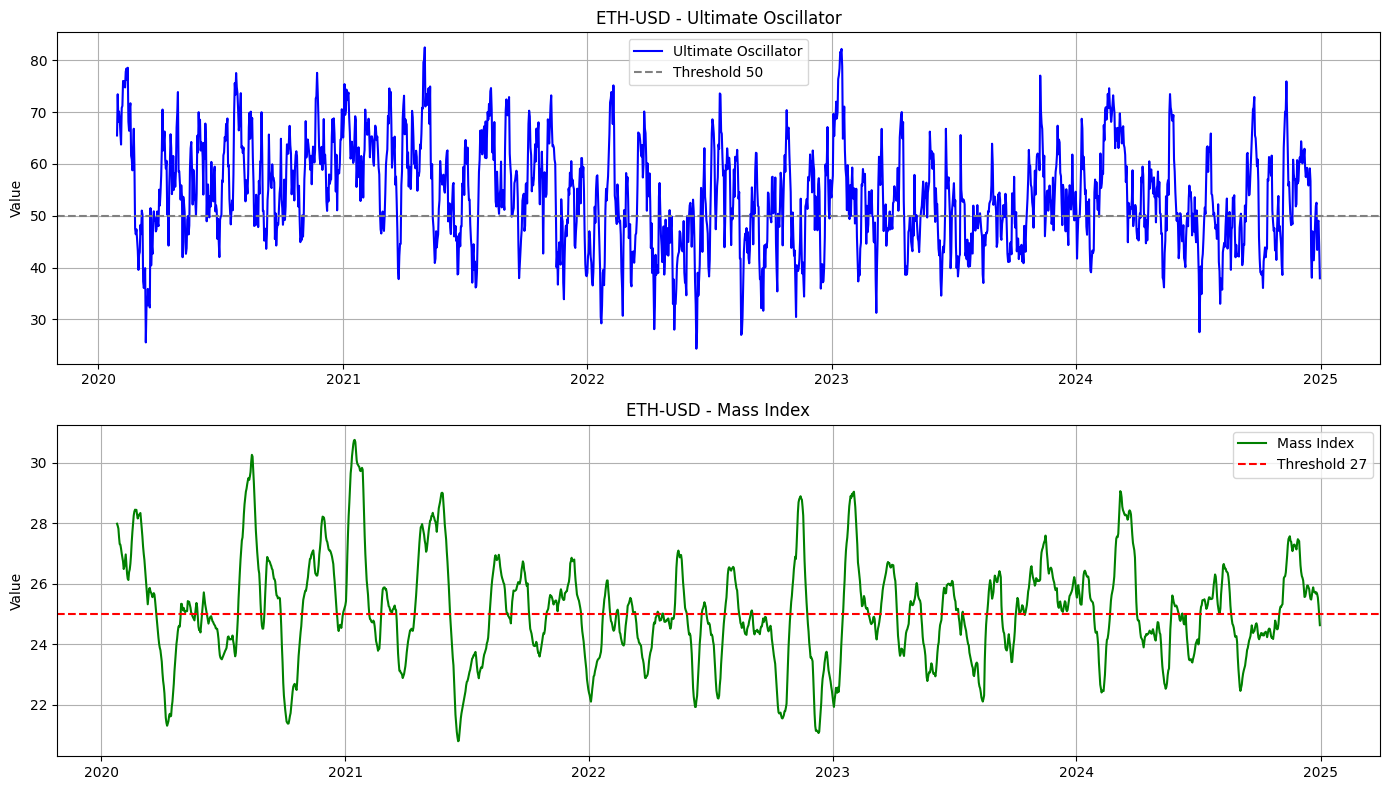

In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Ultimate Oscillator ===
def calculate_ultimate_oscillator(df, short=7, medium=14, long=28):
    high = df['High']
    low = df['Low']
    close = df['Close']

    bp = close - np.minimum(low, close.shift(1))
    tr = np.maximum(high, close.shift(1)) - np.minimum(low, close.shift(1))

    avg7 = bp.rolling(window=short).sum() / tr.rolling(window=short).sum()
    avg14 = bp.rolling(window=medium).sum() / tr.rolling(window=medium).sum()
    avg28 = bp.rolling(window=long).sum() / tr.rolling(window=long).sum()

    ult_osc = 100 * (4 * avg7 + 2 * avg14 + avg28) / (4 + 2 + 1)
    return ult_osc

# === Mass Index ===
def calculate_mass_index(df, ema_period=9, mi_period=25):
    high_low_range = df['High'] - df['Low']
    ema1 = high_low_range.ewm(span=ema_period, adjust=False).mean()
    ema2 = ema1.ewm(span=ema_period, adjust=False).mean()
    mass = (ema1 / ema2).rolling(window=mi_period).sum()
    return mass

# === Parameters ===
symbol = 'ETH-USD'
start_date = '2020-01-01'
end_date = '2025-01-01'

# === Download Data ===
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Calculate Indicators ===
df['UltimateOsc'] = calculate_ultimate_oscillator(df)
df['MassIndex'] = calculate_mass_index(df)

# === Plot ===
plt.figure(figsize=(14, 8))

# Plot Ultimate Oscillator
plt.subplot(2, 1, 1)
plt.plot(df.index, df['UltimateOsc'], label='Ultimate Oscillator', color='blue')
plt.axhline(50, color='gray', linestyle='--', label='Threshold 50')
plt.title(f'{symbol} - Ultimate Oscillator')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot Mass Index
plt.subplot(2, 1, 2)
plt.plot(df.index, df['MassIndex'], label='Mass Index', color='green')
plt.axhline(25, color='red', linestyle='--', label='Threshold 27')
plt.title(f'{symbol} - Mass Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
